In [15]:
import time
import serial
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.fft import fft
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



In [2]:
import glob
import os
import pandas as pd

# Procurar arquivos CSV no diretório especificado
csv_files = glob.glob('../data/*.csv')

# Normalizar os caminhos dos arquivos para usar barras '/'
csv_files = [os.path.normpath(file).replace('\\', '/') for file in csv_files]
for file in csv_files:
    print(file)
    

../data/bci_data_correto1.csv
../data/bci_data_correto10.csv
../data/bci_data_correto2.csv
../data/bci_data_correto3.csv
../data/bci_data_correto4.csv
../data/bci_data_correto5.csv
../data/bci_data_correto6.csv
../data/bci_data_correto7.csv
../data/bci_data_correto8.csv
../data/bci_data_correto9.csv


In [82]:
# Parâmetros 
window_size = 1250  # Número de amostras por janela
overlap = 0.25  # Sobreposição entre janelas
cutoff = 40 # Frequência de corte em Hz



X_features = []
y_labels = []
medicoes = 0

# Filtro passa-baixa
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Definir parâmetros do filtro
frequencia_amostragem = 250  # Taxa de amostragem média em Hz (ajustada para EEG típico)


for file in csv_files:
    # leitura do arquivo csv
    data = pd.read_csv(file, sep=';')
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
    data['VALUE'] = data['VALUE']*(3.3/4098)
    
    print(f'Processando arquivo {file} | {data.shape[0]} amostras\n')
    medicoes += data.shape[0]
    #####################################
    # CRIAR JANELAS
    #####################################

    # Parâmetros
    step_size = int(window_size * (1 - overlap))

    # Lista para armazenar as janelas
    windows = []
    labels = []

    # Criar janelas com sobreposição e atribuir labels
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        
        # Verificar se algum valor na janela tem CONCENTRATION = 1
        if window['CONCENTRATION'].any() == 1:
            labels.append(1)
        else:
            labels.append(0)
            
        windows.append(window)

    # Adicionar as janelas e labels ao array de labels
    y_labels.extend(labels)
    
    #####################################
    # FILTRO EM TODAS JANELAS
    #####################################
    f_windows = []  # Lista para armazenar os DataFrames filtrados

    # Iterar sobre as janelas para aplicar os filtros
    for i, window in enumerate(windows):
        # Extrair dados da janela
        timestamp = np.array(window['TIMESTAMP'])
        value = np.array(window['VALUE'])
        
        # Aplicar filtro passa-baixa
        filtered_value = butter_lowpass_filter(value, cutoff, frequencia_amostragem)
        
        # Criar um DataFrame com os dados filtrados
        filtered_window = pd.DataFrame({
            'TIMESTAMP': timestamp,
            'VALUE': filtered_value,
        })
        
        # Adicionar o DataFrame filtrado à lista
        f_windows.append(filtered_window)
        
    #####################################
    # FFT
    #####################################
    # Inicializar o array para armazenar as características
    ffts = []
    
    # Iterar sobre as janelas
    for window in f_windows:
        # Extrair os valores da primeira janela
        values = window['VALUE'].values - np.mean(window['VALUE'].values)

        # Calcular a taxa de amostragem como o inverso da média das diferenças de tempo
        timestamp_diff = window['TIMESTAMP'].diff().dt.total_seconds()
        sampling_rate = 1 / timestamp_diff[timestamp_diff > 0].mean()

        # Calcular a FFT dos valores
        fft_values = np.abs(fft(values))[:len(values)//2]
        
        # Adicionar a FFT ao array de características
        ffts.append(fft_values)
    
    # Adicionar as características ao array de características
    X_features.extend(ffts)
        
    # print(f'Arquivo {file} processado | {len(ffts)} janelas e {len(labels)} labels\n')
    # print('-----------------------------------\n')

# print total de medicoes separando por . as dezenas
print(f'Total de medições: {medicoes:,}\n')
print('-----------------------------------\n')

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f'Número total de janelas: {len(X_features)}')
print('-----------------------------------\n')

print(f'Número de janelas com CONCENTRATION = 1: {np.sum(y_labels)}')
print(f'Número de janelas com CONCENTRATION = 0: {len(y_labels) - np.sum(y_labels)}')

Processando arquivo ../data/bci_data_correto1.csv | 185001 amostras

Processando arquivo ../data/bci_data_correto10.csv | 153601 amostras

Processando arquivo ../data/bci_data_correto2.csv | 185492 amostras

Processando arquivo ../data/bci_data_correto3.csv | 174240 amostras

Processando arquivo ../data/bci_data_correto4.csv | 155924 amostras

Processando arquivo ../data/bci_data_correto5.csv | 164941 amostras

Processando arquivo ../data/bci_data_correto6.csv | 153751 amostras

Processando arquivo ../data/bci_data_correto7.csv | 108662 amostras

Processando arquivo ../data/bci_data_correto8.csv | 155521 amostras

Processando arquivo ../data/bci_data_correto9.csv | 166140 amostras

Total de medições: 1,603,273

-----------------------------------

Número total de janelas: 1702
-----------------------------------

Número de janelas com CONCENTRATION = 1: 778
Número de janelas com CONCENTRATION = 0: 924


TREINAMENTO

In [83]:
# # nomralize X_features
# scaler = StandardScaler()
# X_features = scaler.fit_transform(X_features)

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)

print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho teste: {X_test.shape}")

Tamanho treino: (1191, 625)
Tamanho teste: (511, 625)


	Classifier: LinearSVC
	Accuracy: 0.6731898238747553
	Precision: 0.6367924528301887
	Recall: 0.6
	F1-score: 0.6178489702517163


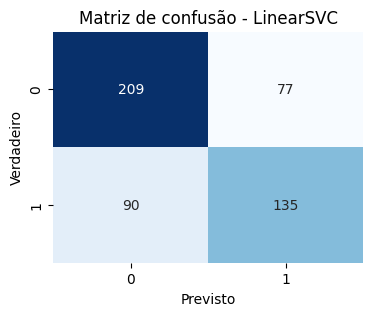

C:\Users\Paulo\AppData\Local\Temp\ipykernel_23412\3423610600.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})], ignore_index=True)


	Classifier: Logistic Regression
	Accuracy: 0.6888454011741683
	Precision: 0.665
	Recall: 0.5911111111111111
	F1-score: 0.6258823529411764


c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


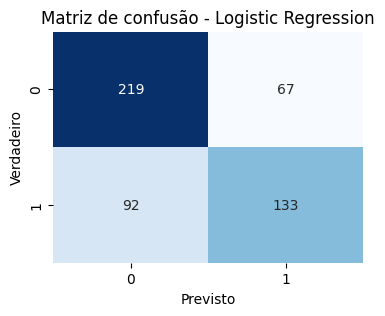



	Classifier: Random Forest
	Accuracy: 0.7279843444227005
	Precision: 0.7311827956989247
	Recall: 0.6044444444444445
	F1-score: 0.6618004866180048


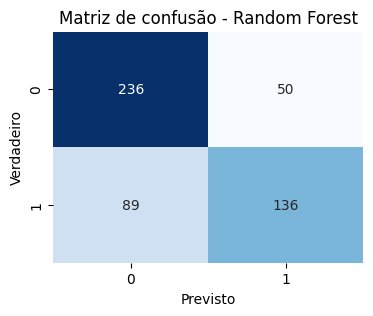



	Classifier: K-Nearest Neighbors
	Accuracy: 0.6046966731898239
	Precision: 0.558974358974359
	Recall: 0.48444444444444446
	F1-score: 0.5190476190476191


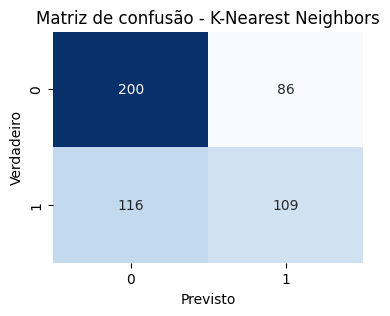



	Classifier: Gradient Boosting
	Accuracy: 0.7045009784735812
	Precision: 0.6761904761904762
	Recall: 0.6311111111111111
	F1-score: 0.6528735632183909


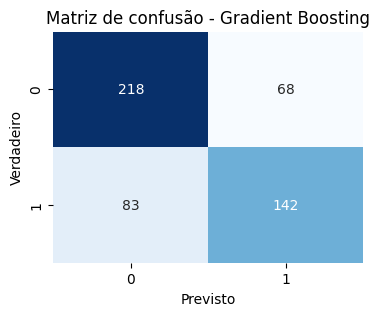



	Classifier: Decision Tree
	Accuracy: 0.5675146771037182
	Precision: 0.5085470085470085
	Recall: 0.5288888888888889
	F1-score: 0.5185185185185185


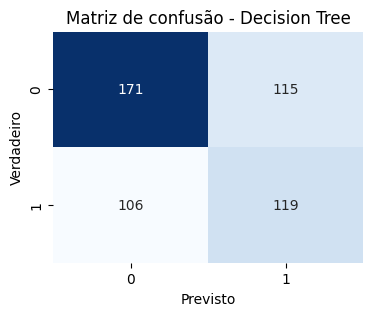



	Classifier: Gaussian Naive Bayes
	Accuracy: 0.6966731898238747
	Precision: 0.6966292134831461
	Recall: 0.5511111111111111
	F1-score: 0.6153846153846154


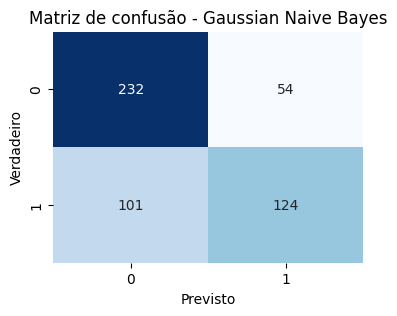



	Classifier: Support Vector Classifier
	Accuracy: 0.7279843444227005
	Precision: 0.7047619047619048
	Recall: 0.6577777777777778
	F1-score: 0.6804597701149425


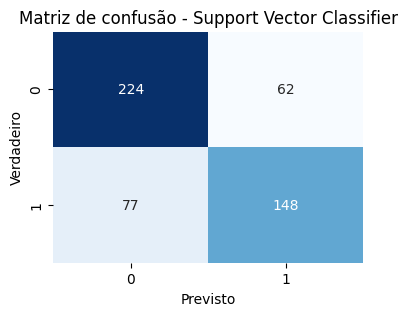

c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	Classifier: AdaBoost Classifier
	Accuracy: 0.6594911937377691
	Precision: 0.6153846153846154
	Recall: 0.6044444444444445
	F1-score: 0.6098654708520179


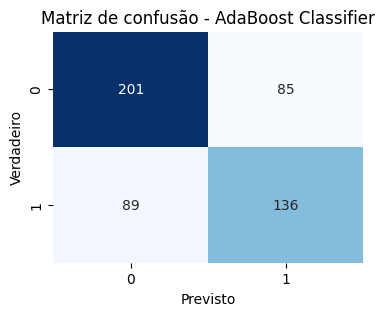



	Classifier: Linear Discriminant Analysis
	Accuracy: 0.6653620352250489
	Precision: 0.6310679611650486
	Recall: 0.5777777777777777
	F1-score: 0.6032482598607889


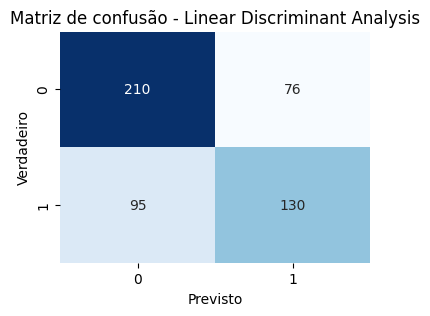



	Classifier: MLP Classifier
	Accuracy: 0.6712328767123288
	Precision: 0.6289592760180995
	Recall: 0.6177777777777778
	F1-score: 0.6233183856502242


c:\Users\Paulo\OneDrive\Área de Trabalho\neuroTech\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


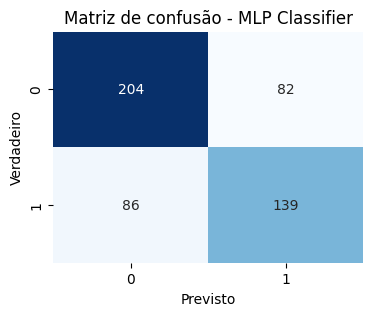

,Model,Accuracy,Precision,Recall,F1
7,Support Vector Classifier,0.727984,0.704762,0.657778,0.680460
2,Random Forest,0.727984,0.731183,0.604444,0.661800
4,Gradient Boosting,0.704501,0.676190,0.631111,0.652874
1,Logistic Regression,0.688845,0.665000,0.591111,0.625882
10,MLP Classifier,0.671233,0.628959,0.617778,0.623318
0,LinearSVC,0.673190,0.636792,0.600000,0.617849
6,Gaussian Naive Bayes,0.696673,0.696629,0.551111,0.615385
8,AdaBoost Classifier,0.659491,0.615385,0.604444,0.609865
9,Linear Discriminant Analysis,0.665362,0.631068,0.577778,0.603248
3,K-Nearest Neighbors,0.604697,0.558974,0.484444,0.519048


In [84]:
classifiers = {
    'LinearSVC': LinearSVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Classifier': SVC(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'MLP Classifier': MLPClassifier()
}


results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Loop sobre cada classificador
for name, clf in classifiers.items():
    # Treinar o classificador
    clf.fit(X_train, y_train)
    
    # Prever os rótulos do conjunto de teste
    y_pred = clf.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Imprimir métricas
    print(f"\tClassifier: {name}")
    print(f"\tAccuracy: {accuracy}")
    print(f"\tPrecision: {precision}")
    print(f"\tRecall: {recall}")
    print(f"\tF1-score: {f1}")
    
    # Calcular a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de confusão - {name}')
    plt.show()
    print("\n")
    
    #create a dataframe with the results linke model name, accuracy, precision, recall and f1
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1]})], ignore_index=True)

# print the results ordered by f1 score and accuracy
results = results.sort_values(by=['F1', 'Accuracy'], ascending=False)
results
